#### 1. Import required libraries

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


from tensorflow.keras.optimizers import Adam 

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats
import pyttsx3 #for audio output

ModuleNotFoundError: No module named 'cv2'

#### 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer modifiable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # color conversion RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Drawing face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Drawing pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Drawing left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Drawing right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame, results)

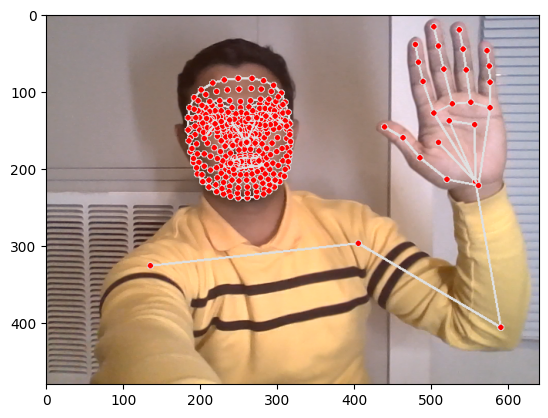

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#### 3. Extract Keypoint Values

In [13]:
def extract_keypoints(results):
    #Pose landmarks
    if results.pose_landmarks:
        pose = []
        for res in results.pose_landmarks.landmark:
            test = np.array([res.x, res.y, res.z, res.visibility])
            pose.append(test)
        pose=np.array(pose).flatten()
    
    else: 
        pose= np.zeros(132)
    
    #Face landmarks
    if results.face_landmarks:
        face = []
        for res in results.face_landmarks.landmark:
            test = np.array([res.x, res.y, res.z])
            face.append(test)
        face=np.array(face).flatten()
    
    else: 
        face= np.zeros(468*3)


    #left hand landmarks
    if results.left_hand_landmarks:
        lh = []
        for res in results.left_hand_landmarks.landmark:
            test = np.array([res.x, res.y, res.z])
            lh.append(test)
        lh=np.array(lh).flatten()
    
    else: 
        lh= np.zeros(21*3)


    #right hand landmarks 
    if results.right_hand_landmarks :
        rh = []
        for res in results.right_hand_landmarks.landmark :
            test = np.array([res.x, res.y, res.z])
            rh.append(test)
        rh=np.array(rh).flatten()
    
    else: 
        rh= np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
len(result_test)

1662

In [16]:

result_test

array([ 0.40765756,  0.34631506, -0.87133682, ...,  0.        ,
        0.        ,  0.        ])

In [17]:
np.save('0', result_test)

In [18]:
np.load('0.npy')

array([ 0.40765756,  0.34631506, -0.87133682, ...,  0.        ,
        0.        ,  0.        ])

#### 4. Setup Folders for Collection

In [19]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['This is', 'sign language', 'detection', 'project'])

# Thirty videos worth of data
no_sequences = 50

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [20]:
DATA_PATH = os.path.join('MP_Data') 

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [21]:
for action in actions:
    sequence = 1
    while True:
        dir_path = os.path.join(DATA_PATH, action, str(sequence))  
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            sequence += 1
        else:
            sequence +=1
        if sequence > no_sequences:
            break

#### 5. Keypoint Values Collect

In [22]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
        # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'COLLECTION INITIALIZING...', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,50, 50), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for "{}" Video Number:- {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for "{}" Video Number:- {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [23]:
cap.release()
cv2.destroyAllWindows()

#### 6. Preprocess Data and Create Labels and Features

In [215]:
label_map = {label:num for num, label in enumerate(actions)}

In [216]:
label_map

{'This is': 0, 'sign language': 1, 'detection': 2, 'project': 3}

In [217]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [218]:
np.array(sequences).shape

(200, 30, 1662)

In [219]:
np.array(labels).shape

(200,)

In [220]:
X = np.array(sequences)

In [221]:
X.shape

(200, 30, 1662)

In [222]:
y = to_categorical(labels).astype(int)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [224]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [225]:
X_test.shape

(20, 30, 1662)

#### 7. Build and Train LSTM Neural Network

In [226]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [227]:
actions.shape[0]

4

In [239]:

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [240]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=10, restore_best_weights=True)


In [241]:
#model.fit(X_train, y_train, epochs=300, callbacks=[tb_callback])
#history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping])


In [242]:
desired_accuracy = 0.90  # desired accuracy
max_attempts = 30 #maximum 
attempt = 0
best_accuracy = 0.0
current_accuracy= 0.0
while attempt < max_attempts and best_accuracy < desired_accuracy:

    #random_initial_weights = [np.random.normal(size=w.shape) for w in model.get_weights()]
    #model.set_weights(random_initial_weights)   #random intialization of weight

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping])
    print(f"Training attempt {attempt + 1}...")    
    evaluated_result = model.evaluate(X_valid, y_valid)
    current_accuracy = evaluated_result[1]
    attempt += 1
    
    if current_accuracy >= best_accuracy:
        best_accuracy = current_accuracy
        best_model_weights = model.get_weights()
        best_history = history.history  
        

model.set_weights(best_model_weights)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {test_accuracy}")

Epoch 1/100
5/5 [==============================] - 6s 667ms/step - loss: 1.8889 - categorical_accuracy: 0.2708 - val_loss: 3.9062 - val_categorical_accuracy: 0.3056
Epoch 2/100
5/5 [==============================] - 0s 43ms/step - loss: 2.2431 - categorical_accuracy: 0.2083 - val_loss: 1.5528 - val_categorical_accuracy: 0.2778
Epoch 3/100
5/5 [==============================] - 0s 45ms/step - loss: 1.5132 - categorical_accuracy: 0.1528 - val_loss: 1.3826 - val_categorical_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 0s 47ms/step - loss: 1.2261 - categorical_accuracy: 0.4306 - val_loss: 1.0115 - val_categorical_accuracy: 0.4167
Epoch 5/100
5/5 [==============================] - 0s 48ms/step - loss: 5.0112 - categorical_accuracy: 0.6111 - val_loss: 1.2077 - val_categorical_accuracy: 0.5000
Epoch 6/100
5/5 [==============================] - 0s 49ms/step - loss: 1.3264 - categorical_accuracy: 0.3403 - val_loss: 1.3931 - val_categorical_accuracy: 0.3333
Epoch 7/100
5/5

In [243]:
model.evaluate(X_valid, y_valid)

2/2 [==============================] - 0s 8ms/step - loss: 0.0775 - categorical_accuracy: 0.9722


[0.07747231423854828, 0.9722222089767456]

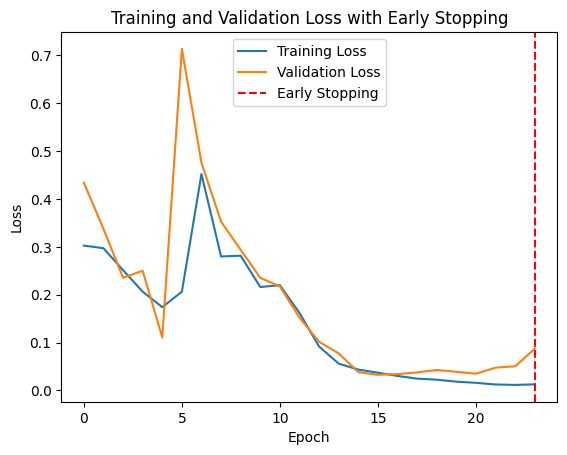

In [244]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Mark the epoch where early stopping occurred
if early_stopping.stopped_epoch is not None:
    plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with Early Stopping')
plt.show()

In [245]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_34 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 4)                 132       
                                                                 
Total params: 596708 (2.28 MB)
Trainable params: 5967

#### 8. Make Predictions

In [246]:

res = model.predict(X_test)

1/1 [==============================] - 0s 439ms/step


In [247]:
actions[np.argmax(res[9])]

'sign language'

In [248]:
actions[np.argmax(y_test[9])]

'sign language'

#### 9. Save Weights

In [249]:
model.save('action.h5')

c:\Users\Rahul A\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [250]:
#del model

In [251]:
model.load_weights('action.h5')

#### 10. Evaluation using Confusion Matrix and Accuracy

In [252]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 30ms/step


In [253]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [254]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[14,  0],
        [ 0,  6]],

       [[16,  0],
        [ 0,  4]],

       [[13,  0],
        [ 0,  7]],

       [[17,  0],
        [ 0,  3]]], dtype=int64)

In [255]:
accuracy_score(ytrue, yhat)

1.0

#### 11. Test in Real Time

In [256]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    num_colors = len(colors)
    for num, prob in enumerate(res):
        color_index = num % num_colors
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[color_index], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [260]:
res

array([[9.33663102e-08, 3.79083396e-08, 4.01117290e-08, 9.99999881e-01],
       [1.14835852e-09, 1.00661993e-10, 7.94899910e-11, 1.00000000e+00],
       [6.25102189e-07, 6.54745847e-04, 9.98380065e-01, 9.64531384e-04],
       [1.79281924e-02, 9.80532646e-01, 1.17182103e-03, 3.67290544e-04],
       [9.99462545e-01, 5.13216364e-04, 5.07181028e-07, 2.37892418e-05],
       [3.56025708e-07, 4.08624794e-04, 9.98741686e-01, 8.49337550e-04],
       [2.27292050e-02, 9.76612031e-01, 4.85691213e-04, 1.73125372e-04],
       [3.32458256e-07, 4.05112107e-04, 9.98825133e-01, 7.69351900e-04],
       [5.77348764e-08, 1.46870327e-04, 9.99591649e-01, 2.61438166e-04],
       [2.57561151e-02, 9.68765914e-01, 3.68194538e-03, 1.79605396e-03],
       [7.55267422e-07, 6.74913055e-04, 9.98133838e-01, 1.19061465e-03],
       [1.41794309e-02, 9.84645188e-01, 8.97247170e-04, 2.78035703e-04],
       [6.62736237e-01, 3.35480332e-01, 4.07472951e-04, 1.37591967e-03],
       [9.99940991e-01, 5.86479837e-05, 1.06455325e

In [261]:


engine = pyttsx3.init()

In [262]:
def speak(text):
    engine.say(text)
    engine.runAndWait()

In [273]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.35
frame_count=0
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.35, min_tracking_confidence=0.35) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame_count += 1

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        
        
        if len(sequence) == 30 and frame_count%30==0:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            if len(sentence) > 0: 
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
                    speak(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
                speak(actions[np.argmax(res)])


            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
            
            

            if len(sentence) > 4: 
                sentence = sentence[-4:]

            # Viz probabilities
            
            cv2.putText(image, 'Pause...', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,50, 50), 4, cv2.LINE_AA)
            cv2.imshow('OpenCV Feed', image)
            cv2.waitKey(2000)
            
        
        image = prob_viz(res, actions, image, colors)  
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
        # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'COLLECTION INITIALIZING...', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255,50, 50), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for "{}" Video Number:- {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for "{}" Video Number:- {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                






                

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()